# Lab Two: Classification

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our data set consists of over 5 million rows of flight information in the domestic United States for the year of 2015. In order to optimize our modeling time, we have narrowed the scope of our classification tasks to the Dallas area only (Dallas Love Field and DFW airports). 

The goal for this project is to build two classification models to predict the following for the DFW area:
1. Whether or not the flight was cancelled (our binary classification model)
2. For delayed flights, how long was the delay (in terms of groups - our multi-class classification model).

Because the scope of our two classification models is different, we will create two data sets for each modelling task.

# 1. Data Preparation

- **[10 points]** Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import altair as alt

In [2]:
# Import data

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
# Read in the data using Pandas
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

C:\Users\megan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Convert time to numeric for binning of the other times
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        "SCHEDULED_TIME",
        "ARRIVAL_TIME",
        "WHEELS_ON",
        "WHEELS_OFF"]
df[cols] = df[cols].apply(pd.to_numeric)

In [4]:
# check variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5819079 entries, 0 to 5819078
Data columns (total 32 columns):
YEAR                   int64
MONTH                  int64
DAY                    int64
DAY_OF_WEEK            int64
AIRLINE_CODE           object
FLIGHT_NUMBER          int64
TAIL_NUMBER            object
ORIGIN_AIRPORT         object
DESTINATION_AIRPORT    object
SCHEDULED_DEPARTURE    int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE               int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED               int64
CANCELLED              int64
CANCELLATION_REASON    object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT

### 1.1 Subset to DFW area

This step will reduce our data down to flights departing from Dallas area airports only.

In [5]:
df = df[(df.ORIGIN_AIRPORT == 'DFW') | (df.ORIGIN_AIRPORT == 'DAL') | 
        (df.DESTINATION_AIRPORT == 'DFW') | (df.DESTINATION_AIRPORT == 'DAL')]

In [6]:
df.shape

(598535, 32)

In [7]:
#check airline counts
df['AIRLINE'].value_counts()

American Airlines Inc.          268550
American Eagle Airlines Inc.    107226
Southwest Airlines Co.          105345
Atlantic Southeast Airlines      49291
Spirit Air Lines                 17047
Delta Air Lines Inc.             13066
Virgin America                   10099
Skywest Airlines Inc.             8265
United Air Lines Inc.             7015
US Airways Inc.                   6162
Alaska Airlines Inc.              2698
Frontier Airlines Inc.            2575
JetBlue Airways                   1196
Name: AIRLINE, dtype: int64

American Airlines is the max class (as expected), but we do still have a decent sample size for some of the smaller airlines. We have reduced the data down from 5 million+ rows to 598,535 rows which is a much more manageable size (although still a lot of data!).

In [8]:
#check cancellations
df['CANCELLED'].value_counts()

0    583787
1     14748
Name: CANCELLED, dtype: int64

This is an unbalanced data set for one of our desired classification items, which is whether or not the flight is cancelled. When we are doing our test and training splits, we can either under or oversample our data, or choose a different cut-off value to optimize sensitivity and specificity in this binary classification.

### 1.2 Create New Variables

First we create a date column for joining up to Dallas weather information.

In [9]:
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

The data contains several timestamp and continuous variables that add additional complexity. In order to simplify the data, we created buckets to analyze similar attributes together.

We first convert SCHEDULED_DEPARTURE, DEPARTURE_TIME, ARRIVAL_TIME, and SCHEDULED_ARRIVAL into buckets based on their timestamp.

    Overnight: 12:00am - 3:59am
    Morning: 4:00am - 10:59am
    Afternoon: 11:00am - 3:59pm
    Evening: 4:01pm - 11:59pm

[Flight] DISTANCE is also divided into buckets.

    Short: 1-99 miles
    Medium: 100-999 miles
    Long: 1,000+ miles



In [10]:
#Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 400, 1100, 1600, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'], 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'], 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'], 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)
df['ACTUAL_ARRIVAL_TIME'] = pd.cut(df['ARRIVAL_TIME'], 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)

# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Look at our data with the buckets
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,FLIGHT_DATE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,19.0,-11.0,17.0,36.0,195.0,193.0,173.0,1464,529.0,3.0,545,532.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,2015-01-01,overnight,overnight,morning,morning,Long
22,2015,1,1,4,NK,214,N632NK,LAS,DFW,103,102.0,-1.0,13.0,115.0,147.0,147.0,128.0,1055,523.0,6.0,530,529.0,-1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Spirit Air Lines,2015-01-01,overnight,overnight,morning,morning,Long
41,2015,1,1,4,NK,972,N606NK,PHX,DFW,159,158.0,-1.0,11.0,209.0,123.0,125.0,103.0,868,452.0,11.0,502,503.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Spirit Air Lines,2015-01-01,overnight,overnight,morning,morning,Medium
42,2015,1,1,4,AA,2459,N3BDAA,PHX,DFW,200,NaN,NaN,NaN,NaN,120.0,NaN,NaN,868,NaN,NaN,500,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,2015-01-01,overnight,NaN,morning,NaN,Medium
70,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,515,703.0,108.0,15.0,718.0,161.0,155.0,133.0,1121,1031.0,7.0,856,1038.0,102.0,0,0,NaN,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,2015-01-01,morning,morning,morning,morning,Long


In [11]:
# Check how many of each bin we have
sched_depart = df['SCHED_DEPARTURE_TIME'].value_counts()
actual_depart = df['ACTUAL_DEPARTURE_TIME'].value_counts()
sched_arrival = df['SCHED_ARRIVAL_TIME'].value_counts()
sched_arrival = df['ACTUAL_ARRIVAL_TIME'].value_counts()
dist_bucket = df['DISTANCE_BUCKET'].value_counts()

print(sched_depart, '\n\n', actual_depart, '\n\n', sched_arrival, '\n\n', dist_bucket)

morning      215255
evening      191908
afternoon    188790
overnight      2582
Name: SCHED_DEPARTURE_TIME, dtype: int64 

 morning      203882
evening      193829
afternoon    183284
overnight      3360
Name: ACTUAL_DEPARTURE_TIME, dtype: int64 

 evening      262011
afternoon    181603
morning      127464
overnight     12143
Name: ACTUAL_ARRIVAL_TIME, dtype: int64 

 Medium    420466
Long      174846
Short       3223
Name: DISTANCE_BUCKET, dtype: int64


In [12]:
# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df['DELAYED'] = df.ARRIVAL_DELAY.apply(get_delay)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,FLIGHT_DATE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,19.0,-11.0,17.0,36.0,195.0,193.0,173.0,1464,529.0,3.0,545,532.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,2015-01-01,overnight,overnight,morning,morning,Long,0
22,2015,1,1,4,NK,214,N632NK,LAS,DFW,103,102.0,-1.0,13.0,115.0,147.0,147.0,128.0,1055,523.0,6.0,530,529.0,-1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Spirit Air Lines,2015-01-01,overnight,overnight,morning,morning,Long,0
41,2015,1,1,4,NK,972,N606NK,PHX,DFW,159,158.0,-1.0,11.0,209.0,123.0,125.0,103.0,868,452.0,11.0,502,503.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Spirit Air Lines,2015-01-01,overnight,overnight,morning,morning,Medium,1
42,2015,1,1,4,AA,2459,N3BDAA,PHX,DFW,200,NaN,NaN,NaN,NaN,120.0,NaN,NaN,868,NaN,NaN,500,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,2015-01-01,overnight,NaN,morning,NaN,Medium,1
70,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,515,703.0,108.0,15.0,718.0,161.0,155.0,133.0,1121,1031.0,7.0,856,1038.0,102.0,0,0,NaN,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,2015-01-01,morning,morning,morning,morning,Long,1


### 1.3 Missing Values

In [13]:
#check missing values
df.isnull().sum()

YEAR                          0
MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE_CODE                  0
FLIGHT_NUMBER                 0
TAIL_NUMBER                1014
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTURE_TIME            14144
DEPARTURE_DELAY           14144
TAXI_OUT                  14611
WHEELS_OFF                14611
SCHEDULED_TIME                1
ELAPSED_TIME              16847
AIR_TIME                  16847
DISTANCE                      0
WHEELS_ON                 15046
TAXI_IN                   15046
SCHEDULED_ARRIVAL             0
ARRIVAL_TIME              15046
ARRIVAL_DELAY             16847
DIVERTED                      0
CANCELLED                     0
CANCELLATION_REASON      583787
AIR_SYSTEM_DELAY         479999
SECURITY_DELAY           479999
AIRLINE_DELAY            479999
LATE_AIRCRAFT_DELAY      479999
WEATHER_DELAY            479999
AIRLINE 

In [14]:
#check cancellations
df['CANCELLED'].value_counts()

0    583787
1     14748
Name: CANCELLED, dtype: int64

In [15]:
#remove non-critical columns WHEELS_ON and WHEELS_OFF
df = df.drop(['WHEELS_ON','WHEELS_OFF'], axis=1)

In [16]:
#add category
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].cat.add_categories(['N'])
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].cat.add_categories(['N'])

#fill missing values with 'N' for 'N/A'
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].fillna('N')
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].fillna('N')

In [17]:
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

C:\Users\megan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [18]:
#check missing values left
df.isnull().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE_CODE                0
FLIGHT_NUMBER               0
TAIL_NUMBER              1014
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTED                    0
DEPARTURE_DELAY             0
TAXI_OUT                    0
SCHEDULED_TIME              1
ELAPSED_TIME             2099
AIR_TIME                 2099
DISTANCE                    0
TAXI_IN                   298
SCHEDULED_ARRIVAL           0
ARRIVED                     0
ARRIVAL_DELAY            2099
DIVERTED                    0
CANCELLED                   0
CANCELLATION_REASON         0
AIR_SYSTEM_DELAY            0
SECURITY_DELAY              0
AIRLINE_DELAY               0
LATE_AIRCRAFT_DELAY         0
WEATHER_DELAY               0
AIRLINE                     0
FLIGHT_DATE                 0
SCHED_DEPARTURE_TIME        0
ACTUAL_DEPARTURE_TIME       0
SCHED_ARRI

In [19]:
#drop remaining missing values and check total cancels left
df = df.dropna()
df['CANCELLED'].value_counts()

0    581688
1     13733
Name: CANCELLED, dtype: int64

In [20]:
#add code here for joining to weather data

#make sure to delete date column after adding in weather data as we can't run model on timestamp data
df = df.drop(columns = 'FLIGHT_DATE')

### 1.4 Log Transformations

As we discovered during Lab 1, the DEPARTURE_DELAY, ARRIVAL_DELAY, DISTANCE, TAXI_IN, ELAPSED_TIME, and AIR_TIME variables are siginificantly right-skewed with a large number of outliers. In order to normalize these values, we did a log transformation.

In [21]:
min(df["DEPARTURE_DELAY"])

-68.0

In [22]:
min(df["ARRIVAL_DELAY"])

-87.0

In [23]:
min(df["DISTANCE"])

89

In [24]:
min(df["TAXI_IN"])

0.0

In [25]:
min(df["ELAPSED_TIME"])

0.0

In [26]:
min(df["AIR_TIME"])

0.0

MB comment: Because we have negative values in the departure and arrival delays, the below code that we have been using overwrites any negative value to 0. I have modified the code to keep 0 if the value is 0, but take the log for everything else.

In [27]:
# Log transformation keeping the 0 in the data sets 
#df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0) 
#df["ARRIVAL_DELAY_Log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0)
#df["DISTANCE_log"]        = df["DISTANCE"].map(lambda i: np.log1p(i) if i > 0 else 0) 
#df["TAXI_IN_Log"]         = df["TAXI_IN"].map(lambda i: np.log1p(i) if i > 0 else 0)
#df["ELAPSED_TIME_log"]    = df["ELAPSED_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 
#df["AIR_TIME_log"]        = df["AIR_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0)

In [28]:
# Log transformation keeping the 0 in the data sets. Because we have negative values, need to offset to make minimum
# equal to zero and not a negative number. For the other vars, no need to run lambda function as min > 0 which improves
# run time
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log(i + 68) if i != -68 else 0) 
df["ARRIVAL_DELAY_log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log(i + 87) if i != -87 else 0)
df["DISTANCE_log"]        = np.log(df["DISTANCE"])
df["TAXI_IN_log"]         = np.log1p(df["TAXI_IN"])
df["ELAPSED_TIME_log"]    = np.log1p(df["ELAPSED_TIME"])
df["AIR_TIME_log"]        = np.log1p(df["AIR_TIME"])

In [29]:
#check calculations
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED,DEPARTURE_DELAY_log,ARRIVAL_DELAY_log,DISTANCE_log,TAXI_IN_log,ELAPSED_TIME_log,AIR_TIME_log
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,1.0,-11.0,17.0,195.0,193.0,173.0,1464,3.0,545,1.0,-13.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,0,4.043051,4.304065,7.288928,1.386294,5.267858,5.159055
22,2015,1,1,4,NK,214,N632NK,LAS,DFW,103,1.0,-1.0,13.0,147.0,147.0,128.0,1055,6.0,530,1.0,-1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Spirit Air Lines,overnight,overnight,morning,morning,Long,0,4.204693,4.454347,6.961296,1.945910,4.997212,4.859812
41,2015,1,1,4,NK,972,N606NK,PHX,DFW,159,1.0,-1.0,11.0,123.0,125.0,103.0,868,11.0,502,1.0,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Spirit Air Lines,overnight,overnight,morning,morning,Medium,1,4.204693,4.477337,6.766192,2.484907,4.836282,4.644391
42,2015,1,1,4,AA,2459,N3BDAA,PHX,DFW,200,1.0,0.0,0.0,120.0,0.0,0.0,868,0.0,500,1.0,0.0,0,1,B,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,N,morning,N,Medium,1,4.219508,4.465908,6.766192,0.000000,0.000000,0.000000
70,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,515,1.0,108.0,15.0,161.0,155.0,133.0,1121,7.0,856,1.0,102.0,0,0,N,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,morning,morning,morning,morning,Long,1,5.170484,5.241747,7.021976,2.079442,5.049856,4.897840


### 1.5 Feature Removals

Here we remove redundant columns to further reduce the data size. Columns that are being removed:

- `YEAR`: All rows are from 2015, no need to include this.
- `AIRLINE`: We have AIRLINE_CODE which is the same information

In [30]:
col_to_drop = ['YEAR','AIRLINE']
df = df.drop(columns = col_to_drop)

In [31]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED,DEPARTURE_DELAY_log,ARRIVAL_DELAY_log,DISTANCE_log,TAXI_IN_log,ELAPSED_TIME_log,AIR_TIME_log
8,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,1.0,-11.0,17.0,195.0,193.0,173.0,1464,3.0,545,1.0,-13.0,0,0,N,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,0,4.043051,4.304065,7.288928,1.386294,5.267858,5.159055
22,1,1,4,NK,214,N632NK,LAS,DFW,103,1.0,-1.0,13.0,147.0,147.0,128.0,1055,6.0,530,1.0,-1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,0,4.204693,4.454347,6.961296,1.945910,4.997212,4.859812
41,1,1,4,NK,972,N606NK,PHX,DFW,159,1.0,-1.0,11.0,123.0,125.0,103.0,868,11.0,502,1.0,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Medium,1,4.204693,4.477337,6.766192,2.484907,4.836282,4.644391
42,1,1,4,AA,2459,N3BDAA,PHX,DFW,200,1.0,0.0,0.0,120.0,0.0,0.0,868,0.0,500,1.0,0.0,0,1,B,0.0,0.0,0.0,0.0,0.0,overnight,N,morning,N,Medium,1,4.219508,4.465908,6.766192,0.000000,0.000000,0.000000
70,1,1,4,AA,1057,N3ASAA,DFW,MIA,515,1.0,108.0,15.0,161.0,155.0,133.0,1121,7.0,856,1.0,102.0,0,0,N,0.0,0.0,0.0,0.0,102.0,morning,morning,morning,morning,Long,1,5.170484,5.241747,7.021976,2.079442,5.049856,4.897840


### 1.6 Encoding

We know that `TAIL_NUMBER`, `ORIGIN_AIRPORT`, and `DESTINATION_AIRPORT` contain a large number of unique values. Before proceeding, we wanted to check and see exactly how many of each we had.

In [32]:
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N906EV    2001
N903EV    1982
N905EV    1963
N904EV    1940
N902EV    1933
N901EV    1894
N880AS    1858
N907EV    1830
N876AS    1784
N877AS    1778
N685AE    1776
N879AS    1771
N687JS    1697
N909EV    1677
N673AE    1676
N908EV    1586
N680AE    1560
N667GB    1532
N671AE    1516
N523SW    1452
N520SW    1443
N528SW    1423
N677AE    1388
N675AE    1346
N684JW    1314
N676AE    1308
N678AE    1255
N522SW    1254
N581AA    1247
N935MQ    1247
          ... 
N12957       2
N307DQ       2
N942UW       2
N195PQ       2
N11187       2
N945DN       2
N3736C       2
N685DA       2
N925SW       2
N534JB       2
N39423       2
N636JB       2
N632SK       2
N14148       2
N584JB       2
N31131       2
N3757D       2
N844MQ       1
N7LFAA       1
N921EV       1
N38417       1
N78438       1
N232FR       1
N804JB       1
N3744F       1
N7LDAA       1
N615QX       1
N7LBAA       1
N713EV       1
N181PQ       1
Name: TAIL_NUMBER, Length: 3700, dtype: int64
DFW    238392
DAL     59471
ATL      98

We have 3,700 different airplanes (TAIL_NUMBER) and 153 different airports (ORIGIN_AIRPORT and DESTINATION_AIRPORT). If we one-hot encode all of these, it would create way too many columns. We would also run the risk of not including a specific airport or tail number in our training data set which would cause an error if it is in our test data set. For that reason, let's set the cut-off to a minimum occurrence of 5 for tail numbers so that we have a greater likelihood of including it within either the train or test set. The minimum group size of the origin and destination airports is sufficiently large to avoid this problem.

In [33]:
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]
print(df['TAIL_NUMBER'].value_counts())

N906EV    2001
N903EV    1982
N905EV    1963
N904EV    1940
N902EV    1933
N901EV    1894
N880AS    1858
N907EV    1830
N876AS    1784
N877AS    1778
N685AE    1776
N879AS    1771
N687JS    1697
N909EV    1677
N673AE    1676
N908EV    1586
N680AE    1560
N667GB    1532
N671AE    1516
N523SW    1452
N520SW    1443
N528SW    1423
N677AE    1388
N675AE    1346
N684JW    1314
N676AE    1308
N678AE    1255
N522SW    1254
N935MQ    1247
N581AA    1247
          ... 
N14977       6
N570JB       6
N664AW       6
N76269       6
N559AS       6
N16183       6
N344AA       6
N835AW       6
N553AS       6
N533AS       6
N37419       6
N748EV       6
N741EV       6
N747UW       6
N11176       6
N331NB       6
N17245       6
N371NB       6
N3747D       6
N8673F       6
N37466       6
N653JB       5
N35407       5
N13161       5
N384AA       5
N69810       5
N23139       5
N17185       5
N807JB       5
N7BGAA       5
Name: TAIL_NUMBER, Length: 3228, dtype: int64


This now reduces to 3,228 unique tail numbers. Hopefully a minimum count of 5 does not give us errors later on.

Next, we will encode these variables. We are not one-hot encoding as there are still too many values. We know this will add some ordinality to the variables but it is simply not feasible to have 4000+ columns without moving to a cloud-based solution.

In [34]:
%%time

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['ORIGIN_AIRPORT_encode'] = labelencoder.fit_transform(df['ORIGIN_AIRPORT'].astype('str'))
df2 = df[['ORIGIN_AIRPORT','ORIGIN_AIRPORT_encode']]
df2 = df2.drop_duplicates(subset=['ORIGIN_AIRPORT'], keep='last')

df2.rename(columns={'ORIGIN_AIRPORT': 'DESTINATION_AIRPORT'}, inplace=True)
df2.rename(columns={'ORIGIN_AIRPORT_encode': 'DESTINATION_AIRPORT_encode'}, inplace=True)

df = pd.merge(df, df2, on='DESTINATION_AIRPORT', how = 'left')
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)

df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

Wall time: 1.59 s


In [35]:
# check which value is DFW and DAL for later reference
df[(df.ORIGIN_AIRPORT == 'DFW') | (df.ORIGIN_AIRPORT == 'DAL')].head(10)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED,DEPARTURE_DELAY_log,ARRIVAL_DELAY_log,DISTANCE_log,TAXI_IN_log,ELAPSED_TIME_log,AIR_TIME_log,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode
4,1,1,4,AA,1057,N3ASAA,DFW,MIA,515,1.0,108.0,15.0,161.0,155.0,133.0,1121,7.0,856,1.0,102.0,0,0,N,0.0,0.0,0.0,0.0,102.0,morning,morning,morning,morning,Long,1,5.170484,5.241747,7.021976,2.079442,5.049856,4.897840,37,94,827
16,1,1,4,AA,72,N5EKAA,DFW,MCO,600,1.0,6.0,18.0,145.0,142.0,120.0,985,4.0,925,1.0,3.0,0,0,N,0.0,0.0,0.0,0.0,0.0,morning,morning,morning,morning,Medium,1,4.304065,4.499810,6.892642,1.609438,4.962845,4.795791,37,87,1719
20,1,1,4,AA,1100,N3GWAA,DFW,LGA,600,1.0,-6.0,33.0,190.0,191.0,154.0,1389,4.0,1010,1.0,-5.0,0,0,N,0.0,0.0,0.0,0.0,0.0,morning,morning,morning,morning,Long,0,4.127134,4.406719,7.236339,1.609438,5.257495,5.043425,37,82,962
39,1,1,4,MQ,3015,N825MQ,DFW,BTR,600,1.0,0.0,0.0,78.0,0.0,0.0,383,0.0,718,1.0,0.0,0,1,B,0.0,0.0,0.0,0.0,0.0,morning,N,morning,N,Medium,1,4.219508,4.465908,5.948035,0.000000,0.000000,0.000000,37,17,2597
50,1,1,4,NK,925,N634NK,DFW,OAK,600,1.0,0.0,13.0,238.0,209.0,188.0,1457,8.0,758,1.0,-29.0,0,0,N,0.0,0.0,0.0,0.0,0.0,morning,morning,morning,morning,Long,0,4.219508,4.060443,7.284135,2.197225,5.347108,5.241747,37,104,1918
51,1,1,4,NK,972,N606NK,DFW,FLL,600,1.0,3.0,56.0,159.0,191.0,131.0,1119,4.0,939,1.0,35.0,0,0,N,35.0,0.0,0.0,0.0,0.0,morning,morning,morning,morning,Long,1,4.262680,4.804021,7.020191,1.609438,5.257495,4.882802,37,48,1778
53,1,1,4,OO,5170,N791SK,DAL,IAH,600,1.0,22.0,12.0,68.0,58.0,41.0,216,5.0,708,1.0,12.0,0,0,N,0.0,0.0,0.0,0.0,0.0,morning,morning,morning,morning,Medium,1,4.499810,4.595120,5.375278,1.791759,4.077537,3.737670,33,67,2445
54,1,1,4,OO,6332,N708SK,DFW,DEN,600,1.0,-4.0,27.0,125.0,138.0,100.0,641,11.0,705,1.0,9.0,0,0,N,0.0,0.0,0.0,0.0,0.0,morning,morning,morning,morning,Medium,1,4.158883,4.564348,6.463029,2.484907,4.934474,4.615121,37,36,2129
55,1,1,4,US,560,N663AW,DFW,PHX,605,1.0,7.0,15.0,157.0,158.0,140.0,868,3.0,742,1.0,8.0,0,0,N,0.0,0.0,0.0,0.0,0.0,morning,morning,morning,morning,Medium,1,4.317488,4.553877,6.766192,1.386294,5.068904,4.948760,37,114,2018
59,1,1,4,F9,133,N951FR,DFW,DEN,605,1.0,57.0,18.0,122.0,117.0,91.0,641,8.0,707,1.0,52.0,0,0,N,0.0,0.0,52.0,0.0,0.0,morning,morning,morning,morning,Medium,1,4.828314,4.934474,6.463029,2.197225,4.770685,4.521789,37,36,3090


`DFW` is `37` and `DAL` is `33`. We also have code above which makes sure the `ORIGIN_AIRPORT` and `DESTINATION_AIRPORT` encodings are the same value by airport.

In [36]:
# Drop original columns
col_to_drop = ['TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop)

For the remaining categorical variables, we can one-hot encode as the number of unique values is significantly fewer.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594044 entries, 0 to 594043
Data columns (total 40 columns):
MONTH                         594044 non-null int64
DAY                           594044 non-null int64
DAY_OF_WEEK                   594044 non-null int64
AIRLINE_CODE                  594044 non-null object
FLIGHT_NUMBER                 594044 non-null int64
SCHEDULED_DEPARTURE           594044 non-null int64
DEPARTED                      594044 non-null float64
DEPARTURE_DELAY               594044 non-null float64
TAXI_OUT                      594044 non-null float64
SCHEDULED_TIME                594044 non-null float64
ELAPSED_TIME                  594044 non-null float64
AIR_TIME                      594044 non-null float64
DISTANCE                      594044 non-null int64
TAXI_IN                       594044 non-null float64
SCHEDULED_ARRIVAL             594044 non-null int64
ARRIVED                       594044 non-null float64
ARRIVAL_DELAY                 594044 non

In [38]:
#total cancel check
df['CANCELLED'].value_counts()

0    580337
1     13707
Name: CANCELLED, dtype: int64

In [39]:
%%time

categorical_columns = ['AIRLINE_CODE', 'CANCELLATION_REASON', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME', 'ACTUAL_ARRIVAL_TIME',
                       'DISTANCE_BUCKET']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns, drop_first = True)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

df_OHE.head()

Wall time: 3.37 s


,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAYED,DEPARTURE_DELAY_log,ARRIVAL_DELAY_log,DISTANCE_log,TAXI_IN_log,ELAPSED_TIME_log,AIR_TIME_log,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,CANCELLATION_REASON_B,CANCELLATION_REASON_C,CANCELLATION_REASON_N,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_morning,ACTUAL_DEPARTURE_TIME_afternoon,ACTUAL_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_N,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,ACTUAL_ARRIVAL_TIME_morning,ACTUAL_ARRIVAL_TIME_afternoon,ACTUAL_ARRIVAL_TIME_evening,ACTUAL_ARRIVAL_TIME_N,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long
0,1,1,4,1112,30,1.0,-11.0,17.0,195.0,193.0,173.0,1464,3.0,545,1.0,-13.0,0,0,0.0,0.0,0.0,0.0,0.0,0,4.043051,4.304065,7.288928,1.386294,5.267858,5.159055,132,37,1031,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1,1,1,4,214,103,1.0,-1.0,13.0,147.0,147.0,128.0,1055,6.0,530,1.0,-1.0,0,0,0.0,0.0,0.0,0.0,0.0,0,4.204693,4.454347,6.961296,1.945910,4.997212,4.859812,75,37,1906,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
2,1,1,4,972,159,1.0,-1.0,11.0,123.0,125.0,103.0,868,11.0,502,1.0,1.0,0,0,0.0,0.0,0.0,0.0,0.0,1,4.204693,4.477337,6.766192,2.484907,4.836282,4.644391,114,37,1778,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,1,1,4,2459,200,1.0,0.0,0.0,120.0,0.0,0.0,868,0.0,500,1.0,0.0,0,1,0.0,0.0,0.0,0.0,0.0,1,4.219508,4.465908,6.766192,0.000000,0.000000,0.000000,114,37,837,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0
4,1,1,4,1057,515,1.0,108.0,15.0,161.0,155.0,133.0,1121,7.0,856,1.0,102.0,0,0,0.0,0.0,0.0,0.0,102.0,1,5.170484,5.241747,7.021976,2.079442,5.049856,4.897840,37,94,827,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1


In [40]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594044 entries, 0 to 594043
Data columns (total 64 columns):
MONTH                              594044 non-null int64
DAY                                594044 non-null int64
DAY_OF_WEEK                        594044 non-null int64
FLIGHT_NUMBER                      594044 non-null int64
SCHEDULED_DEPARTURE                594044 non-null int64
DEPARTED                           594044 non-null float64
DEPARTURE_DELAY                    594044 non-null float64
TAXI_OUT                           594044 non-null float64
SCHEDULED_TIME                     594044 non-null float64
ELAPSED_TIME                       594044 non-null float64
AIR_TIME                           594044 non-null float64
DISTANCE                           594044 non-null int64
TAXI_IN                            594044 non-null float64
SCHEDULED_ARRIVAL                  594044 non-null int64
ARRIVED                            594044 non-null float64
ARRIVAL_DELAY     

In [41]:
#add response variable bucket for delay time
delay_labels = ['Early_<0', 'On_Time_0-10', 'Late_11-30', 'Very_Late_31-60', 'Extremely_Late_61+']
delay_bins   = [-np.inf, 0, 10, 30, 60, np.inf]
df_OHE['DELAY_BUCKET'] = pd.cut(df_OHE['ARRIVAL_DELAY'],
                               bins=delay_bins,
                               labels=delay_labels)

#check counts by bucket
df_OHE['DELAY_BUCKET'].value_counts()

Early_<0              369722
On_Time_0-10           85170
Late_11-30             67959
Extremely_Late_61+     35865
Very_Late_31-60        35328
Name: DELAY_BUCKET, dtype: int64

### 1.7 Make New Data Sets

Here, we will start to remove variables based on our desired response variable and then check correlations for further removals. We will drop the non-transformed versions of the below groups since it is duplicated and will naturally be correlated to the log version.

In [42]:
col_to_drop = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE', 'TAXI_IN', 'ELAPSED_TIME', 'AIR_TIME']
df_OHE = df_OHE.drop(columns = col_to_drop)

In [64]:
#make a copy of our data for each new set
df_cancel = df_OHE
df_delay = df_OHE

#drop delay bucket from cancellation set
df_cancel = df_cancel.drop(columns = 'DELAY_BUCKET')

#### 1.7.1 Delay Data Set

We can remove several variables for our delay bucket group. We will filter out any cancelled flights, as these are not delayed. Then we can also remove `CANCELLED` and our `CANCELLATION_REASON` encoded columns. Because we don't know whether or not the flight will be delayed prior to the analysis, we will also remove `ACTUAL_ARRIVAL_TIME` and `ACTUAL_DEPARTURE_TIME` and all of of our other delay time related columns.

In [65]:
#filter out cancelled flights
df_delay = df_delay[df_delay.CANCELLED == 0]

col_to_drop2 = ['CANCELLED', 'CANCELLATION_REASON_B', 'CANCELLATION_REASON_C', 'CANCELLATION_REASON_N', 
               'ACTUAL_DEPARTURE_TIME_morning', 'ACTUAL_DEPARTURE_TIME_afternoon', 'ACTUAL_DEPARTURE_TIME_evening',
               'ACTUAL_DEPARTURE_TIME_N', 'ACTUAL_ARRIVAL_TIME_morning', 'ACTUAL_ARRIVAL_TIME_afternoon', 
                'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 
                'ACTUAL_ARRIVAL_TIME_evening','ACTUAL_ARRIVAL_TIME_N','AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DELAYED', 
                'DEPARTURE_DELAY_log','ARRIVAL_DELAY_log', 'ELAPSED_TIME_log', 'DEPARTED', 'ARRIVED',
               'TAXI_IN_log', 'AIR_TIME_log']

df_delay = df_delay.drop(columns = col_to_drop2)

In [66]:
df_delay.shape

(580337, 32)

In [67]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 580337 entries, 0 to 594043
Data columns (total 32 columns):
MONTH                             580337 non-null int64
DAY                               580337 non-null int64
DAY_OF_WEEK                       580337 non-null int64
FLIGHT_NUMBER                     580337 non-null int64
TAXI_OUT                          580337 non-null float64
SCHEDULED_TIME                    580337 non-null float64
DIVERTED                          580337 non-null int64
DISTANCE_log                      580337 non-null float64
ORIGIN_AIRPORT_encode             580337 non-null int32
DESTINATION_AIRPORT_encode        580337 non-null int32
TAIL_NUMBER_encode                580337 non-null int32
AIRLINE_CODE_AS                   580337 non-null uint8
AIRLINE_CODE_B6                   580337 non-null uint8
AIRLINE_CODE_DL                   580337 non-null uint8
AIRLINE_CODE_EV                   580337 non-null uint8
AIRLINE_CODE_F9                   580337 no

#### 1.7.2 Cancelled data set

### 1.8 Check Correlations

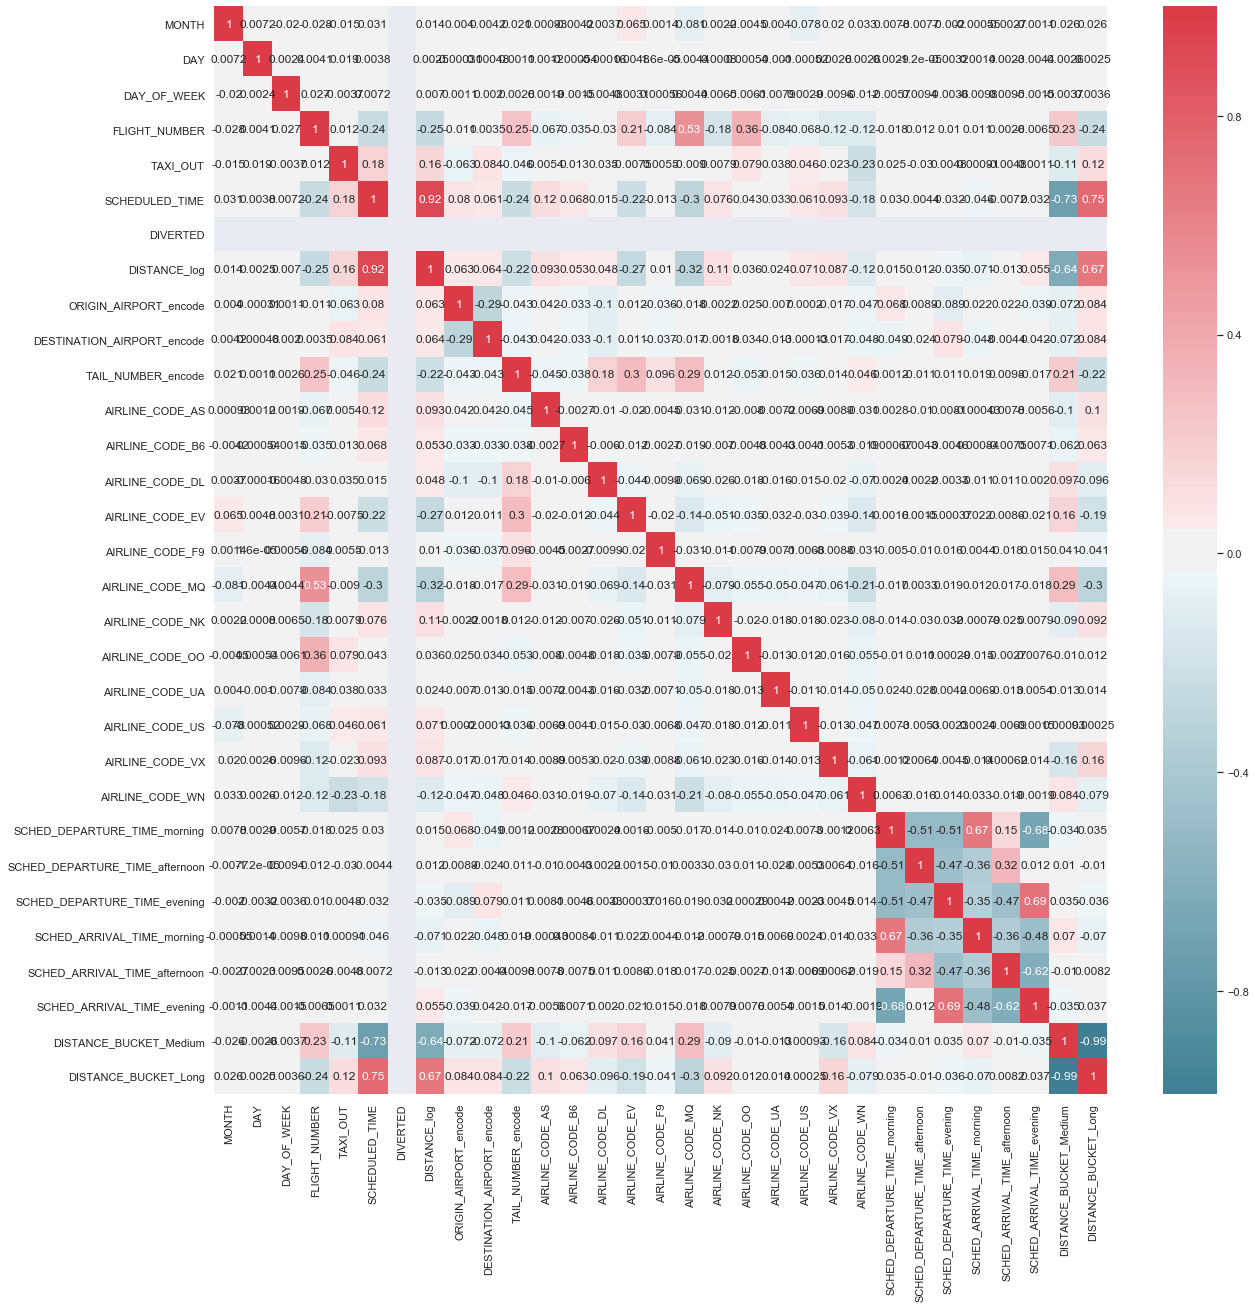

In [68]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Create heatmap
sns.heatmap(df_delay.corr(), cmap=cmap, annot = True)

For our delay data set, we still see a high correlation between `DISTANCE_log` and `SCHEDULED_TIME` at a value of 0.92. Let's remove the `DISTANCE_log` value as we have distance buckets already. Let's also remove `DIVERTED` as the heat map shows us we have all `0` values in this column so it's not useful.

In [69]:
col_to_drop3 = ['DISTANCE_log', 'SCHEDULED_TIME', 'DIVERTED']

df_delay = df_delay.drop(columns = col_to_drop3)

- **[5 points]** Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

  
#### Modeling and Evaluation (70 points total)

- **[10 points]** Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
- **[10 points]** Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.
- **[20 points]** Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.
- **[10 points]** Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.
- **[10 points]** Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.
- **[10 points]** Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

#### Deployment (5 points total)

- **[5 points]** How useful is your model for interested parties (i.e., the companies or
organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

#### Exceptional Work (10 points total)

- You have free reign to provide additional modeling.
- One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?